### Model sieci konwolucyjnej z wykorzystaniem spektrogramów Mel'a i augmentacją danych audio

### Import bibliotek

In [1]:
import sys
import os

# Dodaj katalog główny projektu do sys.path
current_dir = (
    os.path.dirname(os.path.abspath(__file__))
    if "__file__" in globals()
    else os.getcwd()
)
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Katalog główny projektu: {project_root}")
print(f"Czy katalog src istnieje: {os.path.exists(os.path.join(project_root, 'src'))}")

model_output_dir = os.path.join(project_root, "src", "CNN_ed", "model_outputs")
os.makedirs(model_output_dir, exist_ok=True)
print(f"Wyniki modelu będą zapisywane w: {model_output_dir}")

import librosa
import librosa.display
import numpy as np
from datasets import load_from_disk
import matplotlib.pyplot as plt
import random
import json

# Klasyfikacja ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from src.config import DATASET_PATH
from src.create_data import download_and_save_dataset

# Wizualizacja
import seaborn as sns

Katalog główny projektu: c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition
Czy katalog src istnieje: True


### Wczytanie zbioru nEMO

In [2]:
# Weryfikacja istnienia folderu z danymi oraz załadowanie zbioru danych
dataset_path = DATASET_PATH
if os.path.exists(dataset_path):
    try:
        print("Rozpoczęcie ładowania datasetu z dysku...")
        dataset = load_from_disk(dataset_path)
    except Exception as e:
        print(f"Wystąpił błąd podczas ładowania datasetu: {e}")
        print("Inicjowanie ponownego pobierania datasetu...")
        dataset = download_and_save_dataset()
else:
    print("Folder 'data' nie został znaleziony. Inicjowanie pobierania datasetu...")
    dataset = download_and_save_dataset()

# Sprawdź strukturę datasetu i wybierz właściwy split
if hasattr(dataset, "keys"):
    print(f"Dostępne splits: {list(dataset.keys())}")
    # Użyj split 'train' jeśli dostępny
    if "train" in dataset:
        dataset = dataset["train"]
        print("Używam split 'train'")
    else:
        # Jeśli nie ma 'train', użyj pierwszego dostępnego
        first_key = list(dataset.keys())[0]
        dataset = dataset[first_key]
        print(f"Używam split '{first_key}'")

print(f"Rozmiar datasetu: {len(dataset)}")
print(f"Przykładowy sample: {dataset[0] if len(dataset) > 0 else 'Brak danych'}")

Rozpoczęcie ładowania datasetu z dysku...
Dostępne splits: ['train']
Używam split 'train'
Rozmiar datasetu: 4481
Przykładowy sample: {'file_id': 'WR0_surprised_64', 'audio': {'path': None, 'array': array([ 6.10351562e-05, -3.05175781e-05, -3.05175781e-05, ...,
        6.10351562e-05, -1.22070312e-04,  1.83105469e-04]), 'sampling_rate': 24000}, 'emotion': 'surprised', 'raw_text': 'Ucho wykrywa dźwięki o różnej częstotliwości.', 'normalized_text': 'ucho wykrywa dźwięki o różnej częstotliwości', 'speaker_id': 'WR0', 'gender': 'male', 'age': 23}


### Zastosowanie augmentacji plików audio

In [3]:
"""Dodaje biały szum do audio."""


def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio


"""Rozciąga czas (przyspiesza lub spowalnia) audio."""


def time_stretch(audio, rate=None):
    if rate is None:
        rate = np.random.uniform(0.85, 1.15)
    return librosa.effects.time_stretch(y=audio, rate=rate)


"""Zmienia wysokość tonu audio."""


def pitch_shift(audio, sr, n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


"""Zmienia głośność audio."""


def change_volume(audio, volume_factor=None):
    if volume_factor is None:
        volume_factor = np.random.uniform(0.8, 1.2)
    return audio * volume_factor


"""Aplikuje losowe augmentacje z określonym prawdopodobieństwem."""


def apply_augmentation(audio, sr, augment_prob=0.5):
    augmented = np.copy(audio)

    if random.random() < augment_prob:
        augmented = add_noise(augmented, noise_factor=random.uniform(0.001, 0.01))

    if random.random() < augment_prob:
        augmented = time_stretch(augmented)

    if random.random() < augment_prob:
        augmented = pitch_shift(augmented, sr)

    if random.random() < augment_prob:
        augmented = change_volume(augmented)

    return augmented

### Przygotowanie spektrogramów Mel'a 

In [4]:
def audio_to_mel_spectrogram(audio_array, sr=24000):
    n_fft = 1024
    hop_length = 256
    audio_array = audio_array / (np.max(np.abs(audio_array)) + 1e-10)
    pre_emphasis = np.append(audio_array[0], audio_array[1:] - 0.97 * audio_array[:-1])

    mel_spec = librosa.feature.melspectrogram(
        y=pre_emphasis,
        sr=sr,
        n_mels=80,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0,
        fmax=8000,
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    mel_spec_norm = (mel_spec_db - np.min(mel_spec_db)) / (
        np.max(mel_spec_db) - np.min(mel_spec_db) + 1e-10
    )
    return mel_spec_norm

###  Przygotowanie danych

In [5]:
audio_files = [sample["audio"]["array"] for sample in dataset]
sample_rates = [sample["audio"]["sampling_rate"] for sample in dataset]
labels = [sample["emotion"] for sample in dataset]

# Konwertowanie etykiet emocji na liczby
emotion_labels = {emotion: idx for idx, emotion in enumerate(sorted(set(labels)))}
numeric_labels = [emotion_labels[label] for label in labels]

print("Mapowanie etykiet emocji:")
for emotion, idx in emotion_labels.items():
    print(f"  {emotion}: {idx}")

mel_specs = []
mel_aug_labels = []

# Docelowy rozmiar spektrogramu
mel_target_size = (80, 200)

# Dla każdej próbki audio
for audio, sr, label in zip(audio_files, sample_rates, numeric_labels):
    # Przycinanie lub paddowanie audio do stałej długości (5 sekund)
    max_len = 5 * sr
    if len(audio) > max_len:
        start = np.random.randint(0, len(audio) - max_len)
        audio = audio[start : start + max_len]
    else:
        padding = np.zeros(max_len - len(audio))
        audio = np.concatenate([audio, padding])

    # Dodanie oryginalnej próbki
    mel_spec = audio_to_mel_spectrogram(audio, sr=sr)

    # Zmiana rozmiaru spektrogramu (PyTorch używa PIL/CV2 do resize)
    mel_spec_tensor = (
        torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    )
    mel_spec_resized = F.interpolate(
        mel_spec_tensor, size=mel_target_size, mode="bilinear", align_corners=False
    )
    mel_spec = mel_spec_resized.squeeze().numpy()

    mel_specs.append(mel_spec)
    mel_aug_labels.append(label)

    # Dodanie augmentowanych próbek
    for _ in range(2):
        augmented_audio = apply_augmentation(audio, sr)
        aug_mel_spec = audio_to_mel_spectrogram(augmented_audio, sr=sr)

        aug_mel_spec_tensor = (
            torch.tensor(aug_mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        )
        aug_mel_spec_resized = F.interpolate(
            aug_mel_spec_tensor,
            size=mel_target_size,
            mode="bilinear",
            align_corners=False,
        )
        aug_mel_spec = aug_mel_spec_resized.squeeze().numpy()

        mel_specs.append(aug_mel_spec)
        mel_aug_labels.append(label)

# Konwersja na numpy arrays dla CNN (PyTorch format: (batch, channels, height, width))
X_mel = np.array(mel_specs).reshape(-1, 1, mel_target_size[0], mel_target_size[1])
y_mel = np.array(mel_aug_labels).astype("int64")

# Wyświetlanie informacji o kształcie danych
print(f"Kształt danych X: {X_mel.shape}")
print(f"Kształt danych y: {y_mel.shape}")

Mapowanie etykiet emocji:
  anger: 0
  fear: 1
  happiness: 2
  neutral: 3
  sadness: 4
  surprised: 5
Kształt danych X: (13443, 1, 80, 200)
Kształt danych y: (13443,)


### Podział na zbiory: treningowy, walidacyjny i testowy. Najpierw dzielimy indeksy, aby zapewnić spójność podziału między różnymi cechami

In [6]:
indices = np.arange(len(y_mel))
indices_train, indices_temp, y_train, y_temp = train_test_split(
    indices, y_mel, test_size=0.3, random_state=42, stratify=y_mel
)
indices_val, indices_test, y_val, y_test = train_test_split(
    indices_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


X_mel_train, X_mel_val, X_mel_test = (
    X_mel[indices_train],
    X_mel[indices_val],
    X_mel[indices_test],
)

print(f"Rozmiar zbioru treningowego: {len(y_train)} próbek")
print(f"Rozmiar zbioru walidacyjnego: {len(y_val)} próbek")
print(f"Rozmiar zbioru testowego: {len(y_test)} próbek")

# Wyświetl rozkład klas w zbiorze treningowym
class_counts = np.bincount(y_train)
print("\nRozkład klas w zbiorze treningowym:")
for label, count in enumerate(class_counts):
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {count} próbek")

# Obliczenie wag klas dla zrównoważenia
class_weights = {}
total_samples = len(y_train)
n_classes = len(emotion_labels)
for label, count in enumerate(class_counts):
    class_weights[label] = total_samples / (n_classes * count)

print("\nWagi klas:")
for label, weight in class_weights.items():
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {weight:.4f}")

# Konwersja wag klas na tensor PyTorch
class_weights_tensor = torch.tensor(
    [class_weights[i] for i in range(len(class_weights))], dtype=torch.float32
)

Rozmiar zbioru treningowego: 9410 próbek
Rozmiar zbioru walidacyjnego: 2016 próbek
Rozmiar zbioru testowego: 2017 próbek

Rozkład klas w zbiorze treningowym:
  anger: 1573 próbek
  fear: 1545 próbek
  happiness: 1573 próbek
  neutral: 1699 próbek
  sadness: 1615 próbek
  surprised: 1405 próbek

Wagi klas:
  anger: 0.9970
  fear: 1.0151
  happiness: 0.9970
  neutral: 0.9231
  sadness: 0.9711
  surprised: 1.1163


### Trenowanie modelu

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()

        self.batch_norm_input = nn.BatchNorm2d(1)

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.4)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.5)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.batch_norm_input(x)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x


def create_cnn_model(input_shape, num_classes):
    return CNNModel(input_shape, num_classes)


# Funkcja zmieniająca współczynnik uczenia w zależności od epoki
def lr_scheduler_func(epoch, initial_lr):
    if epoch < 5:
        return initial_lr
    elif epoch < 10:
        return initial_lr * 0.5
    elif epoch < 15:
        return initial_lr * 0.25
    else:
        return initial_lr * 0.1


# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


# Przygotowanie danych w formacie PyTorch
X_mel_train_tensor = torch.tensor(X_mel_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_mel_val_tensor = torch.tensor(X_mel_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_mel_test_tensor = torch.tensor(X_mel_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(X_mel_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_mel_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_mel_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\n===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL'a =====")

# Utworzenie modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

cnn_model = create_cnn_model((1, 80, 200), len(emotion_labels))
cnn_model.to(device)

# Podsumowanie modelu
total_params = sum(p.numel() for p in cnn_model.parameters())
print(f"Liczba parametrów modelu: {total_params}")

# Loss function z wagami klas
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Historia treningu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Trening
epochs = 20
initial_lr = 0.001

for epoch in range(epochs):
    # Aktualizacja learning rate
    new_lr = lr_scheduler_func(epoch, initial_lr)
    for param_group in optimizer.param_groups:
        param_group["lr"] = new_lr

    # Trening
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Walidacja
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Obliczenie średnich
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total

    # Zapisanie historii
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoka {epoch + 1}/{epochs}: "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {new_lr:.6f}"
    )

    # Early stopping
    if early_stopping(val_loss, cnn_model):
        print(f"Early stopping w epoce {epoch + 1}")
        break

# Zapisanie najlepszego modelu
torch.save(
    cnn_model.state_dict(), os.path.join(model_output_dir, "best_cnn_emotion_model.pt")
)
print("Zapisano najlepszy model do pliku best_cnn_emotion_model.pt")

# Ocena modelu na zbiorze testowym
cnn_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f"\nDokładność na zbiorze testowym: {test_acc:.4f}")

y_pred_classes = np.array(all_predictions)
y_test_final = np.array(all_labels)


===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL'a =====
Używane urządzenie: cpu
Liczba parametrów modelu: 109960
Epoka 1/20: Train Loss: 1.7938, Train Acc: 0.1710, Val Loss: 1.7891, Val Acc: 0.1910, LR: 0.001000
Epoka 2/20: Train Loss: 1.7909, Train Acc: 0.1765, Val Loss: 1.7840, Val Acc: 0.1870, LR: 0.001000
Epoka 3/20: Train Loss: 1.7830, Train Acc: 0.1942, Val Loss: 1.7640, Val Acc: 0.2312, LR: 0.001000
Epoka 4/20: Train Loss: 1.7596, Train Acc: 0.2216, Val Loss: 1.7266, Val Acc: 0.2723, LR: 0.001000
Epoka 5/20: Train Loss: 1.7318, Train Acc: 0.2448, Val Loss: 1.6678, Val Acc: 0.3070, LR: 0.001000
Epoka 6/20: Train Loss: 1.7032, Train Acc: 0.2688, Val Loss: 1.6478, Val Acc: 0.3160, LR: 0.000500
Epoka 7/20: Train Loss: 1.6755, Train Acc: 0.2832, Val Loss: 1.6201, Val Acc: 0.3239, LR: 0.000500
Epoka 8/20: Train Loss: 1.6622, Train Acc: 0.2959, Val Loss: 1.6071, Val Acc: 0.3418, LR: 0.000500
Epoka 9/20: Train Loss: 1.6489, Train Acc: 0.3031, Val Loss: 1.5853, Val Acc: 0.3343, LR: 0.000

### Metryki modelu


Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.33      0.68      0.44       337
           1       0.69      0.30      0.42       332
           2       0.40      0.08      0.13       337
           3       0.34      0.50      0.40       364
           4       0.45      0.71      0.55       346
           5       0.47      0.03      0.05       301

    accuracy                           0.39      2017
   macro avg       0.44      0.38      0.33      2017
weighted avg       0.44      0.39      0.34      2017


Macierz pomyłek:
[[228   0   6  94   8   1]
 [ 71  99  11  50  98   3]
 [202  22  26  70  15   2]
 [ 62   0   8 181 112   1]
 [  7  16   2  72 247   2]
 [131   7  12  69  74   8]]

Macro F1-score: 0.3310


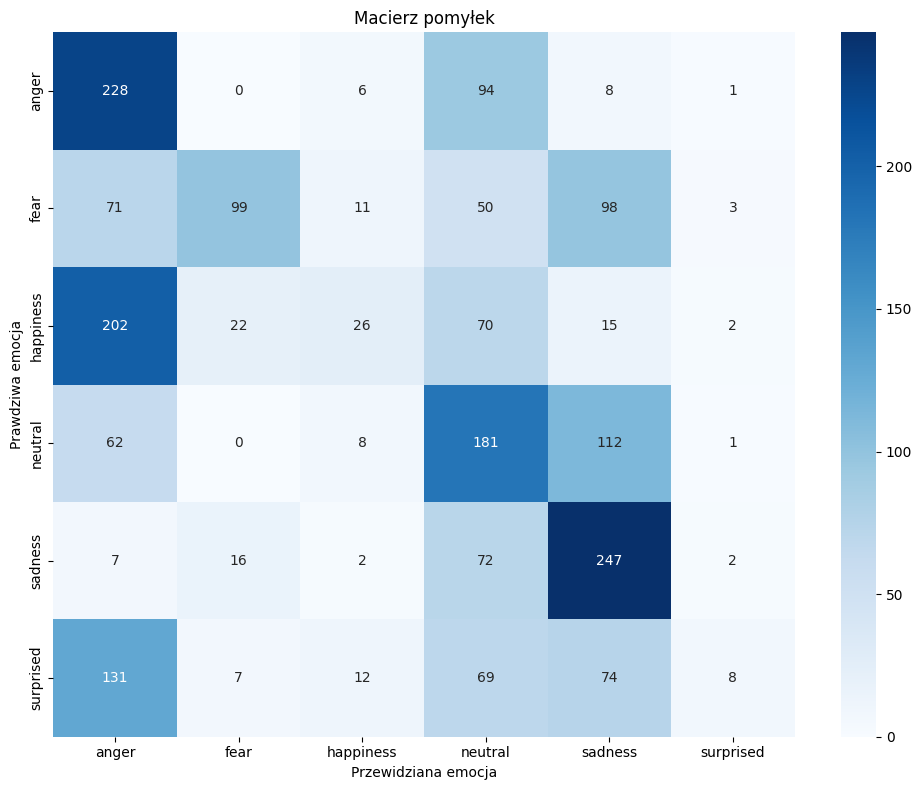

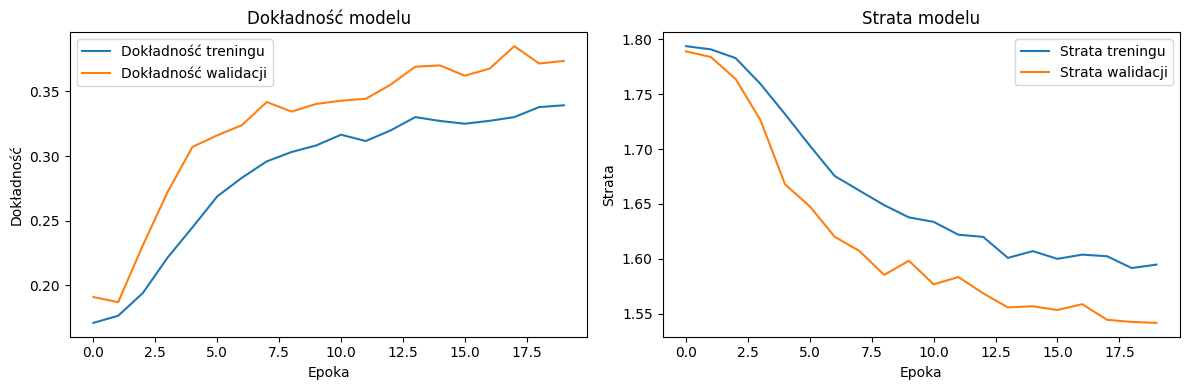

Zapisano mapowanie etykiet do pliku emotion_labels.json


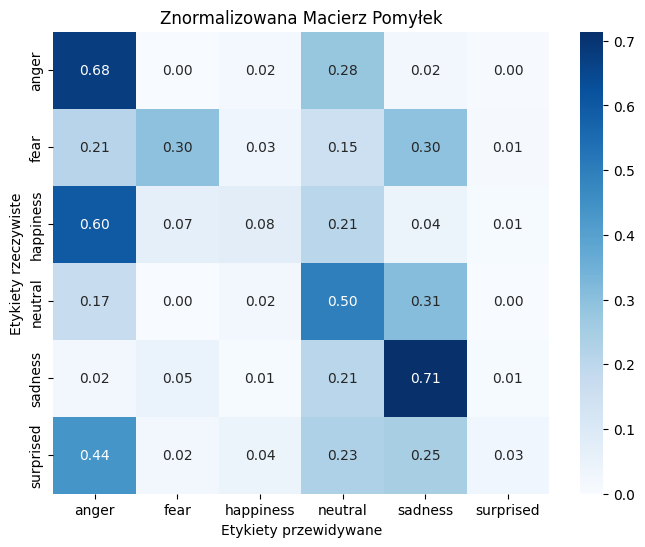

In [ ]:
# Raport klasyfikacji
print("\nRaport klasyfikacji:")
print(classification_report(y_test_final, y_pred_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test_final, y_pred_classes)
print("\nMacierz pomyłek:")
print(cm)

# Obliczanie F1-score
f1_macro = f1_score(y_test_final, y_pred_classes, average="macro")
print(f"\nMacro F1-score: {f1_macro:.4f}")

# Wykresy
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[k for k in emotion_labels.keys()],
    yticklabels=[k for k in emotion_labels.keys()],
)
plt.xlabel("Przewidziana emocja")
plt.ylabel("Prawdziwa emocja")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.savefig(os.path.join(model_output_dir, "confusion_matrix.png"))
plt.show()

# Historia treningu
cnn_history = {
    "accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "loss": train_losses,
    "val_loss": val_losses,
}

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history["accuracy"], label="Dokładność treningu")
plt.plot(cnn_history["val_accuracy"], label="Dokładność walidacji")
plt.title("Dokładność modelu")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history["loss"], label="Strata treningu")
plt.plot(cnn_history["val_loss"], label="Strata walidacji")
plt.title("Strata modelu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(model_output_dir, "training_history.png"))
plt.show()

# Zapisanie mapowania etykiet
with open(os.path.join(model_output_dir, "emotion_labels.json"), "w") as f:
    json.dump(emotion_labels, f)
print("Zapisano mapowanie etykiet do pliku emotion_labels.json")

# %%
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
)
plt.xlabel("Etykiety przewidywane")
plt.ylabel("Etykiety rzeczywiste")
plt.title("Znormalizowana Macierz Pomyłek")
plt.savefig(
    os.path.join(model_output_dir, "normalized_confusion_matrix.png"),
    format="png",
    dpi=300,
)
plt.show()

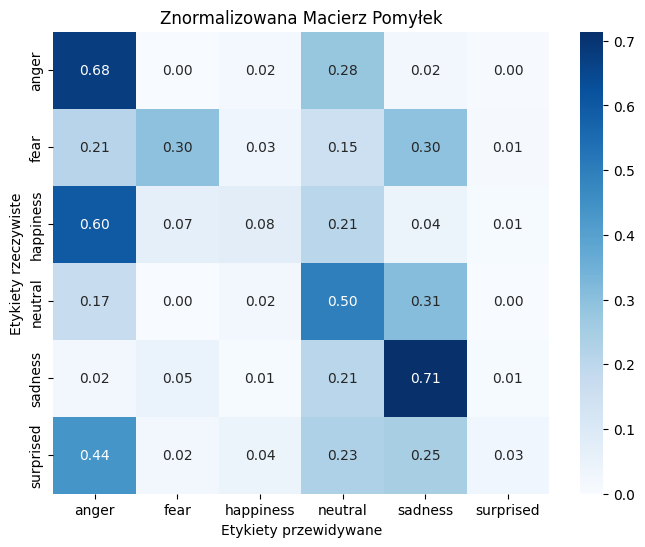

In [9]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
)
plt.xlabel("Etykiety przewidywane")
plt.ylabel("Etykiety rzeczywiste")
plt.title("Znormalizowana Macierz Pomyłek")
plt.savefig("normalized_confusion_matrix.png", format="png", dpi=300)
plt.show()